<a href="https://colab.research.google.com/github/Mic-73/GenAI/blob/main/HW3/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Author: Michael Wood

Purpose: In this assignment, we create and train a Variational Autoencoder (VAE) model in Keras to learn representations of the Street View House Numbers (SVHN) dataset and explore its performance with different latent dimensions.
*   The SVHN dataset is often used for evaluating machine learning algorithms, particularly in the field of computer vision (http://ufldl.stanford.edu/housenumbersLinks to an external site.)
*   It consists of labeled digits extracted from natural images of house numbers collected from Google Street View.
*   Each image in the dataset is 32x32 pixels and contains a single digit, ranging from 0 to 9, often presented in varying orientations, backgrounds, and lighting conditions.
*   The dataset is divided into a training set, which contains around 73,000 samples, and a test set with over 26,000 samples.
*   The SVHN dataset presents a challenge because of the cluttered backgrounds and the variability in digit styles.

Note: Initial code for importing and loading the data and setting up training the model was taken from the assignment page on Canvas. Initial code for setting up the encoder, decoder, Sampling class, and VAE class was taken from the course's Github repo here: https://github.com/bforoura/GenAI/blob/main/Module3/vae_fashion.ipynb. The code was modified to fit the assignment's requirements.

---

# Code

## 1. Load and Preprocess the SVHN Dataset

In [1]:
#@title Importing Data

!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!pip install graphviz pydot

--2024-10-09 16:48:53--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  2.83MB/s    in 66s     

2024-10-09 16:50:00 (2.61 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-09 16:50:00--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  2.71MB/s    in 32s     

2024-10-09 16:50:32 (1.89 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [2]:
#@title Importing Libraries

# numerical operations
import numpy as np

# used for plotting
import matplotlib.pyplot as plt

# used for tensors
import tensorflow as tf

import keras
from keras import layers
#from keras import ops

from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
    utils
)
#from notebooks.utils import

# Extra libraries for callbacks and graph visualization
import tensorflow.keras.backend as K
import pydot
from graphviz import Digraph

import graphviz
from tensorflow.keras.utils import plot_model
from PIL import Image
import io

from scipy.stats import norm

from scipy.io import loadmat

In [5]:
#@title Loading the Data

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


## 2. Build a Variational Autoencoder

In [13]:
#@title Sampling Class

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [28]:
#@title VAE Class

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [29]:
#@title Build VAE Model with a Function

def build_vae(latent_dim):
    # Encoder
    encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input")
    x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
    x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()

    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
    x = layers.Reshape(shape_before_flattening)(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    decoder_output = layers.Conv2D(
        3,
        (3, 3),
        strides=1,
        activation="sigmoid",
        padding="same",
        name="decoder_output",
    )(x)

    decoder = models.Model(decoder_input, decoder_output)
    decoder.summary()
    vae = VAE(encoder, decoder)
    return vae

## 3. Train the VAE with Different Latent Dimensions

In [ ]:
#@title Parameters for the Model

IMAGE_SIZE = 32
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3
EMBEDDING_DIM = 2
EPOCHS = 50
BETA = 500

In [30]:
#@title Train the VAE Model

latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, x_test))
    # Training the model with a batch size of 64 over 50 epochs.

Training VAE with latent dimension: 2
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_19 (Conv2D)          (None, 8, 8, 64)             18496     ['conv2d_18[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 4, 4, 128)            73856     ['conv2d_19[0][0]']           
                                                      

## 4. Visualize the Results

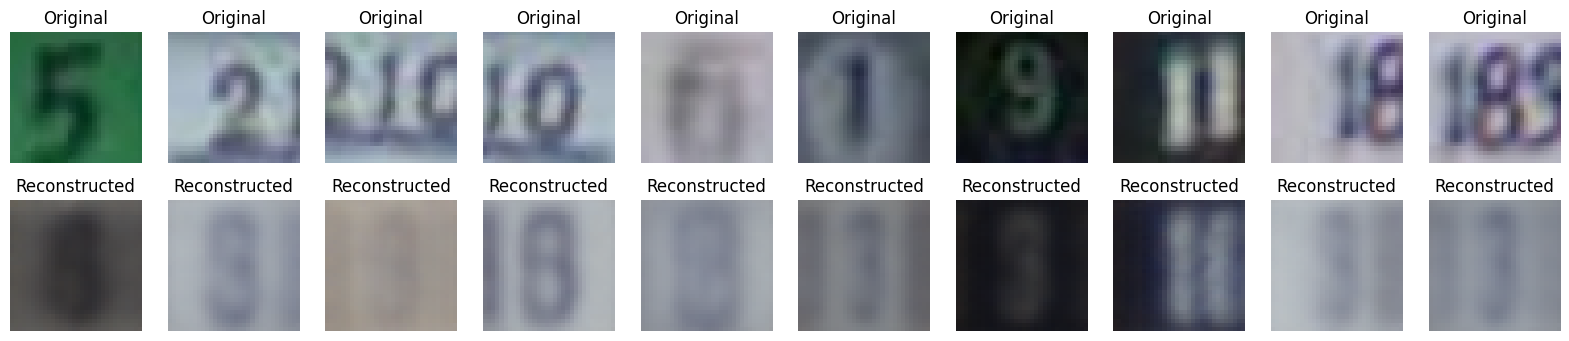

In [41]:
#@title Visualizations of Original vs Reconstructed Images

# Generate reconstructions
z_mean, z_log_var, reconstructions = vae(x_test)

# Set up the figure
plt.figure(figsize=(20, 4))

# Number of images to display
n_images = 10

# Original images
for i in range(n_images):
    # Display original
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(x_test[i])  # SVHN images are already in range [0, 1]
    plt.title("Original")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(reconstructions[i])  # Should also be in range [0, 1]
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

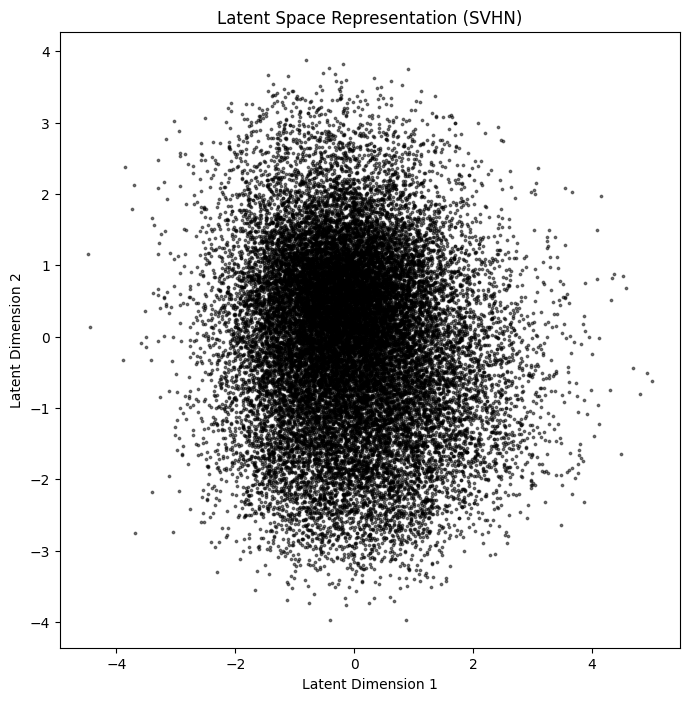

In [44]:
#@title Visualization of the Latent Space Representations

# Encode the test images
z_mean, z_log_var, _ = vae.encoder(x_test)

# Show the encoded points in 2D space
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(_[:, 0], _[:, 1], c="black", alpha=0.5, s=3)
plt.title('Latent Space Representation (SVHN)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

---
# Discussion Points

Process:
*   I only trained for one model with a batch size of 64 over 50 epochs. This took around an hour and a half in the TPU runtime.
*   I did not train further on 100 epochs because that would seem to take too long and would not yield any signifcantly better results. The loss did not seem to be improving much at 50 epochs regardless.
*   I did not train further with a batch size of 32 because of time constraints as well. I also did not believe that it would yield any significantly greater results on this dataset.




Comparison of Original and Reconstructed Images from Above:
*   Clarity: The VAE captures the structure of certain numbers well such as 1, 8, and 9 while struggling to capture the structure of other numbers such as 0, 2, and 5. A lot of the reconstructed images from the VAE are not fully as clear as a lot of the original images, but some of them are recognizable even if they are not entirely accurate.  
*   Distortion: There are some significant distortions or loss of data in the reconstructed images. For example, when there are more than 2 numbers, some of the numbers can be lost in the reconstructed images. This may indicate that the VAE needs improvement in dealing with numbers in the 100s and above or images with more than 2 numbers.  
*   Variability: Even though the model may not always be extremely accurate, it does seem that it keeps a consistent performance across a variety of styles and backgrounds. It has a higher precision even if the accuracy is lower.
*   Generalization: The model seems to have been able to capture the underlying distribution of the data. It can generate numbers that it has seen from the original dataset, and it seems to construct new numbers from the latent space as well. Even if the reconstructed images may not be exactly accurate or clear, it can at least be seen that the model is reconstructing images of numbers. Obviously, the model will need to be refined more to achieve more accurate and concise results.  
---